run this

In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges, gen_num_edges_undirected
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re
from matplotlib.transforms import Affine2D

In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
all_methods = [
  "brute('BRANCH_N_BOUND')",
  "brute('BRUTE_FORCE')",
  "brute('BRUTE_FORCE_COMPLETE')",
  "brute('FAST_BOUND')",
  "ilp()",
  "kalp()",
  "kalp(threads=4)"
]

method_name_dict = {
  "brute('BRANCH_N_BOUND')" : "Branch and bound",
  "brute('BRUTE_FORCE')" : "Brute force",
  "brute('BRUTE_FORCE_COMPLETE')" : "Brute force (complete)",
  "brute('FAST_BOUND')" : "Fast bound",
  "ilp()" : "ILP",
  "kalp()" : "KaLP single threaded",
  "kalp(threads=4)" : "KaLP on 4 threads",
}

color_assignment = {method : col for method, col in zip(all_methods, colors)}
color_assignment

{"brute('BRANCH_N_BOUND')": '#1f77b4',
 "brute('BRUTE_FORCE')": '#ff7f0e',
 "brute('BRUTE_FORCE_COMPLETE')": '#2ca02c',
 "brute('FAST_BOUND')": '#d62728',
 'ilp()': '#9467bd',
 'kalp()': '#8c564b',
 'kalp(threads=4)': '#e377c2'}

In [167]:
def generate():
  return [
    gen_num_edges_undirected(30, round(30 * degree / 2))
      for degree in np.arange(1.2, 3.7,0.2) for _ in range(50)
      # np.arange(1, 3.3, 0.3) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
	Solver("brute", "BRANCH_N_BOUND"),
	Solver("brute", "BRUTE_FORCE_COMPLETE"),
  Solver("ilp"),
	Solver("kalp", threads=4),
	Solver("kalp"),
], params_code = params_code, override_benchmark_path="../benchmarks/all_methods_1.2-3.6_50_runs")

benchmark.benchmark_path


'../benchmarks/all_methods_1.2-3.6_50_runs(1)'

In [168]:
np.arange(1.2, 3.7,0.2)

array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6])

run this

In [3]:
benchmark = Benchmark.load("../final_benchmarks/all_methods_1.2-3.6_50_runs_latest/")

In [4]:
benchmark.run(retryFailures=True, timeout=10 * 60)


NameError: name 'benchmark' is not defined

run this and everything after

In [4]:
df = benchmark.get_dataframe()
df.head()

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[6, 28, 2, 7, 26, 21, 3, 19]",0.000006,7.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
1,"[4, 17, 8, 19, 7, 5, 26, 1, 11, 14, 10]",0.000010,10.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
2,"[4, 15, 25, 20, 14, 29]",0.000007,5.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
3,"[0, 19, 2, 16, 18, 10, 3]",0.000005,6.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2
4,"[6, 21, 18, 12, 10, 19, 0, 8, 4, 3, 29, 2, 7]",0.000007,12.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),30,36,1.2


In [5]:
all_methods = sorted(list(set(df["solver_name"])))
all_methods

["brute('BRANCH_N_BOUND')",
 "brute('BRUTE_FORCE')",
 "brute('BRUTE_FORCE_COMPLETE')",
 "brute('FAST_BOUND')",
 'ilp()',
 'kalp()',
 'kalp(threads=4)']

run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

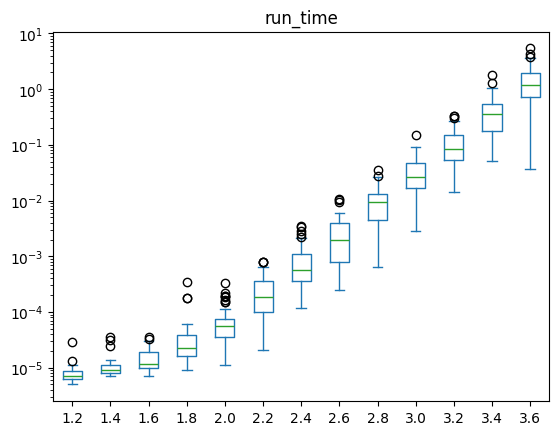

In [6]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


In [7]:
def build_plotting_dataframes(benchmark: Benchmark):
  df = benchmark.get_dataframe()
  df_grouped = df \
    .groupby(['average_out_degree', 'solver', 'solver_name']) \
    .agg({
      "run_time": ["mean", "median", "std"], 
      "failure": "any"
    }) \
    .reset_index() \
    .rename(columns={"any": ""})

  df_grouped.columns = [a + ("_" + b if b != "" else "")  for (a,b) in df_grouped.columns]

  df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
  to_plot = df_grouped_failures_removed.pivot(
    index='average_out_degree', 
    columns='solver_name', 
    values=['run_time_mean', 'run_time_std']
  ).reset_index()

  return df, df_grouped, df_grouped_failures_removed, to_plot

In [8]:
df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

In [9]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRANCH_N_BOUND'),13
1,brute('BRUTE_FORCE'),13
2,brute('BRUTE_FORCE_COMPLETE'),13
3,brute('FAST_BOUND'),13
4,ilp(),10
5,kalp(),13
6,kalp(threads=4),13


In [10]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time_mean,run_time_median,run_time_std,failure
0,1.2,0,brute('FAST_BOUND'),0.000008,0.000007,0.000003,False
1,1.2,1,brute('BRUTE_FORCE'),0.000006,0.000006,0.000003,False
2,1.2,2,brute('BRANCH_N_BOUND'),0.000015,0.000012,0.000009,False
3,1.2,3,brute('BRUTE_FORCE_COMPLETE'),0.000007,0.000006,0.000004,False
4,1.2,4,ilp(),0.987792,0.845592,0.428626,False


In [11]:
to_plot.head()


average_out_degree           run_time_mean                       \
solver_name                    brute('BRANCH_N_BOUND') brute('BRUTE_FORCE')   
0                          1.2                0.000015             0.000006   
1                          1.4                0.000022             0.000009   
2                          1.6                0.000052             0.000016   
3                          1.8                0.000137             0.000045   
4                          2.0                0.000342             0.000095   

                                                                         \
solver_name brute('BRUTE_FORCE_COMPLETE') brute('FAST_BOUND')     ilp()   
0                                0.000007            0.000008  0.987792   
1                                0.000009            0.000010  1.836209   
2                                0.000016            0.000015  5.543277   
3                                0.000044            0.000039  3.782058   
4                                0.000096            0.000074  2.610913   

                                                 run_time_std  \
solver_name    kalp() kalp(threads=4) brute('BRANCH_N_BOUND')   
0            1.052151        1.245375                0.000009   
1            1.132533        1.359332                0.000014   
2            1.295544        1.619271                0.000037   
3            1.430449        1.806507                0.000124   
4            1.679194        2.019431                0.000226   

                                                                \
solver_name brute('BRUTE_FORCE') brute('BRUTE_FORCE_COMPLETE')   
0                       0.000003                      0.000004   
1                       0.000004                      0.000004   
2                       0.000009                      0.000012   
3                       0.000053                      0.000054   
4                       0.000066                      0.000070   

                                                                      
solver_name brute('FAST_BOUND')      ilp()    kalp() kalp(threads=4)  
0                      0.000003   0.428626  0.097912        0.136261  
1                      0.000006   1.904013  0.113851        0.164144  
2                      0.000007  10.744854  0.139784        0.176045  
3                      0.000054   6.918942  0.117512        0.165360  
4                      0.000062   1.993240  0.121018        0.125739

In [12]:
def setup_info(to_plot):
    plt.title('Running time by average degree')
    plt.ylabel("run-time (seconds)")
    plt.xlabel("mean degree")
    methods = list(to_plot.columns.droplevel())
    plt.legend([method_name_dict[m] for m in methods[1:len(methods)//2+1]], loc='center left', bbox_to_anchor=(1, 0.5))
  
def plt_with_scatter(benchmark, offset_arg = None):
    df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

    fig, ax = plt.subplots()

    to_plot.plot(
        style="o-", 
        x="average_out_degree", 
        y="run_time_mean", 
        color=color_assignment, 
        ax=ax
    )

    offsets = offset_arg if offset_arg != None else [0 for _ in benchmark.solver_names()]

    for offset, solver_name in zip(offsets, benchmark.solver_names()):
        solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
        plt.scatter(
            solver_df['average_out_degree'] + offset,  
            solver_df['run_time'], 
            label=solver_name, 
            alpha=0.2, 
            s=7,
            color=color_assignment[solver_name]
        )
    setup_info(to_plot)


def plot_with_symmetric_errbars(benchmark, offsets_arg = None):
    df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

    fig, ax = plt.subplots()

    to_plot.plot(
        style="o-",
        x="average_out_degree",
        y="run_time_mean", 
        color=color_assignment,
        ax=ax,
    )

    offsets = offsets_arg if offsets_arg != None else [0 for _ in benchmark.solver_names()]

    for offset, solver_name in zip(offsets, benchmark.solver_names()):
        plt.errorbar(
        to_plot['average_out_degree'] + offset,
        to_plot['run_time_mean'][solver_name],
        yerr = to_plot['run_time_std'][solver_name],
        fmt='none',
        capsize=3,
        alpha=0.5,
        color=color_assignment[solver_name],
        )
    setup_info(to_plot)


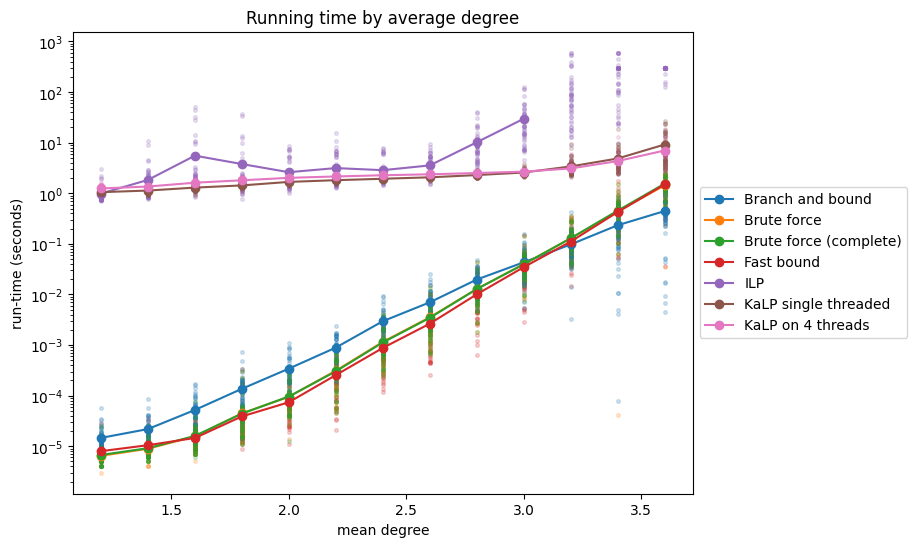

In [13]:
plt_with_scatter(benchmark)

plt.yscale('log')

plt.gcf().set_size_inches(8, 6)

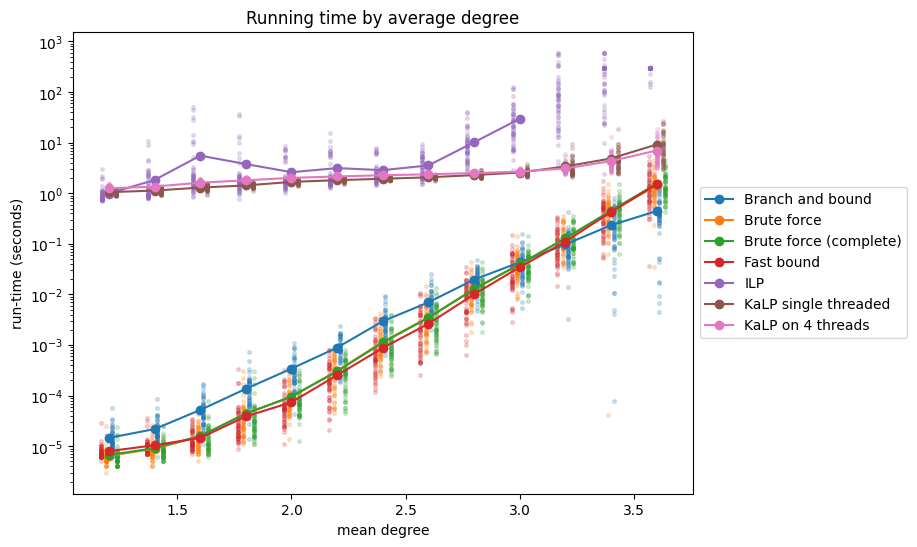

In [14]:
plt_with_scatter(benchmark, list(np.linspace(-0.035,0.035,4)) + list(np.linspace(-0.03,0.03,3)))

plt.yscale("log")
plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

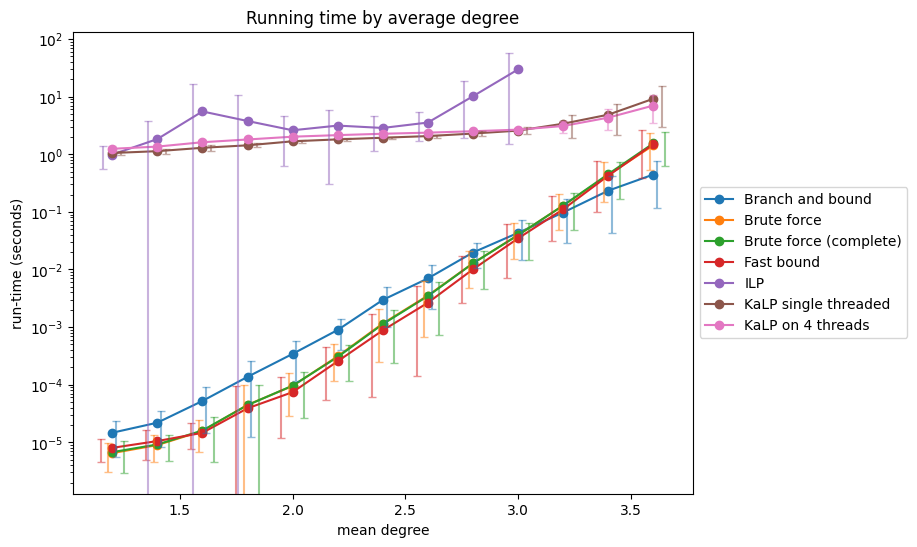

In [15]:
plot_with_symmetric_errbars(benchmark, list(np.linspace(-0.05,0.05,4)) + list(np.linspace(-0.04,0.04,3)))

plt.yscale("log")

plt.gcf().set_size_inches(8, 6)